In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pylab as plt
import back_test_bot as bb
import matplotlib.ticker as mtick

In [3]:
df = bb.fetch_btc_history(interval="1h", start_date="2023-01-01")

In [4]:
# Compute rolling VWAP
df["vwap"] = bb.rolling_vwap(df, window=6)

In [32]:
# Detect deviations > 3%
df = bb.detect_deviation(df, threshold=0.001)

In [33]:
df = bb.trade_direction(df)

In [34]:
df = bb.best_bot(df)

In [35]:
df_sample = df.tail(200)

In [36]:
def plot_trade_events(df):
    fig, ax = plt.subplots(figsize=(10,8))
    df.plot(ax=ax, x='timestamp',y='price')
    df.plot(ax=ax, x='timestamp',y='deviation',secondary_y=True,alpha=0.2,ls='-.')
    df.plot(ax=ax, x='timestamp',y='vwap',color='k',ls=':')
    df[df['direction']==1].plot.scatter(ax=ax, x='timestamp',y='price', color='green',label = 'buy')
    df[df['direction']==-1].plot.scatter(ax=ax, x='timestamp',y='price', color='red', label = "sell")
    ax.legend(ncols=5)

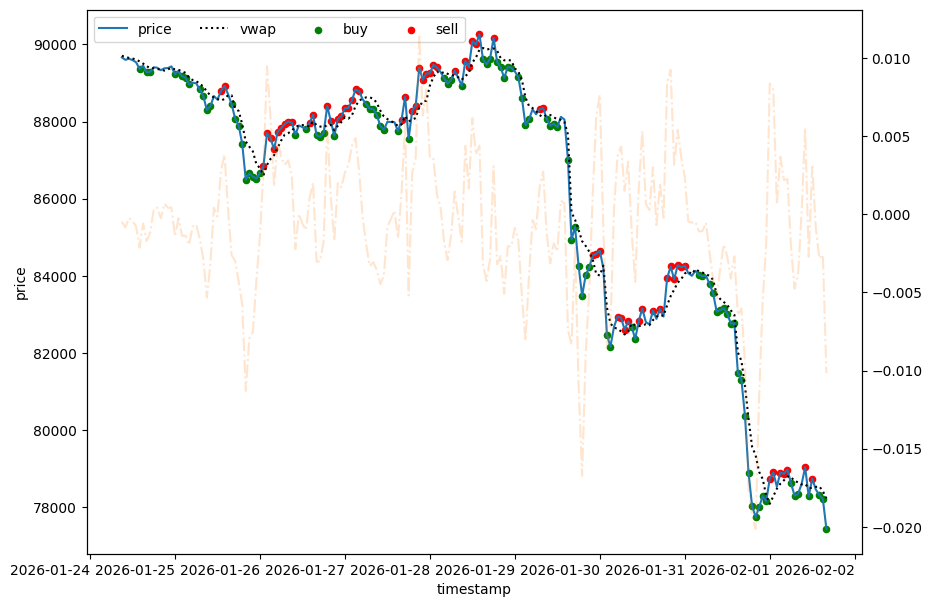

In [37]:
plot_trade_events(df_sample)

In [38]:
df['direction'].value_counts()

direction
-1    10634
 1     9544
 0     6885
Name: count, dtype: int64

#### Populate wallet

In [42]:
df = bb.update_wallet(df, wallet_value=100, wallet_value_fraction=0.2)

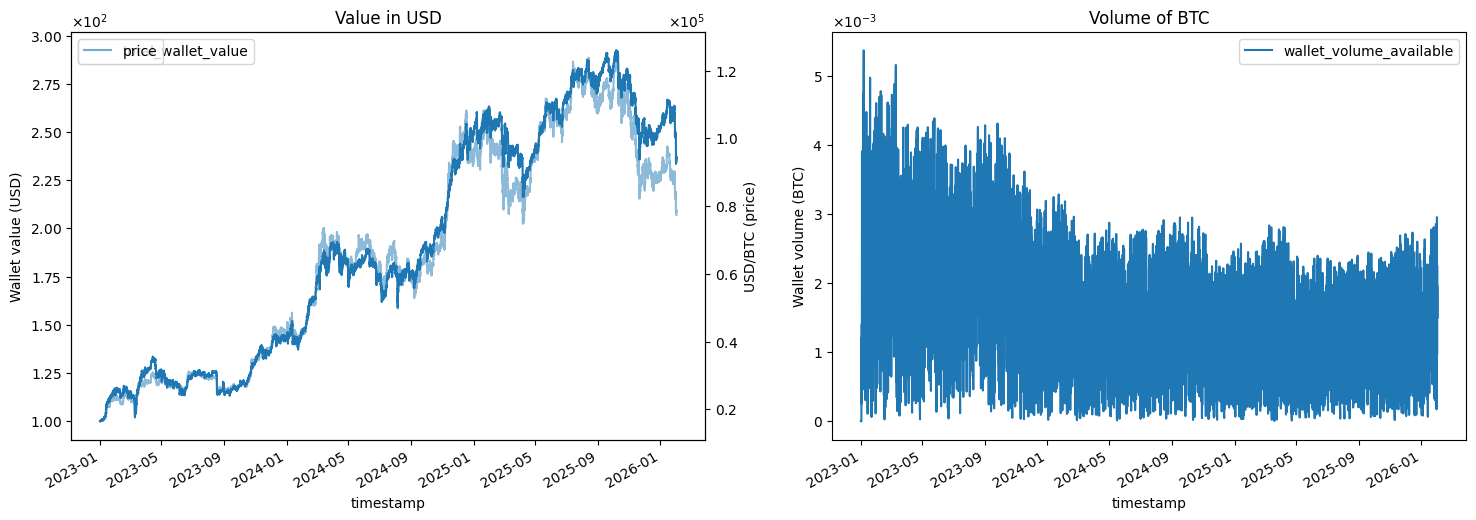

In [45]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

# Left panel
df.plot(ax=ax[0], x='timestamp', y='total_wallet_value', ylabel="Wallet value (USD)", title="Value in USD")
ax[0].yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

ax2 = ax[0].twinx()
df.plot(ax=ax2, x='timestamp', y='price', alpha=0.5, ylabel="USD/BTC (price)")
ax2.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# Right panel
df.plot(ax=ax[1], x='timestamp', y='wallet_volume_available', ylabel="Wallet volume (BTC)", title="Volume of BTC")
ax[1].yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))


In [46]:
df.tail()

,timestamp,high,low,price,volume,vwap,deviation,signal,direction,max_profit,wallet_value_available,wallet_volume_available,trade_value,trade_volume,total_wallet_value
27058,2026-02-01 11:59:59,78877.89,78279.72,78743.56,539.38656,78504.166956,0.003049,True,-1,598.17,119.838794,0.001490,-29.328714,-0.000372,237.153651
27059,2026-02-01 12:59:59,78760.00,78244.00,78459.67,620.90729,78526.967638,-0.000857,False,0,516.00,119.838794,0.001490,0.000000,0.000000,236.730702
27060,2026-02-01 13:59:59,78768.68,78203.21,78317.51,482.47432,78540.397357,-0.002838,True,1,565.47,95.871035,0.001796,23.967759,0.000306,236.518907
27061,2026-02-01 14:59:59,78520.00,77236.68,78211.12,1658.37078,78415.043823,-0.002601,True,1,1283.32,76.696828,0.002041,19.174207,0.000245,236.327845
27062,2026-02-01 15:59:59,78254.20,77130.25,77435.38,591.06366,78230.796965,-0.010168,True,1,1123.95,61.357462,0.002239,15.339366,0.000198,234.744538


In [15]:
def plot_profit(df):
    cum_max = round(df['max_profit'].sum())
    df.plot(x='timestamp',y='max_profit', ylabel = 'Profit (USD)', title = f'Cumulative max: ${cum_max}')

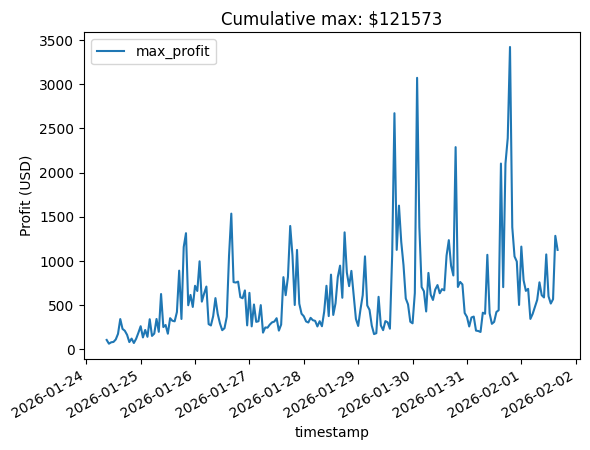

In [16]:
plot_profit(df_sample)

In [17]:
df['direction'].value_counts(normalize=True)

direction
 0    0.946495
-1    0.029154
 1    0.024351
Name: proportion, dtype: float64

## Fourier transform

In [18]:
# 5. Fourier analysis
price_series = df.set_index("timestamp")["price"]
returns = bb.detrend_series(price_series, method="log_return")

In [19]:
# 14-day rolling FFT on hourly data
fft_window = 24*7
dominant_cycles = bb.dominant_cycle(
    returns,
    window=fft_window,
    sampling_interval=1.0
)

In [20]:
# Align output
cycle_df = pd.DataFrame({
    "timestamp": returns.index[fft_window:],
    "dominant_cycle_hours": dominant_cycles
})

(0.0, 5.0)

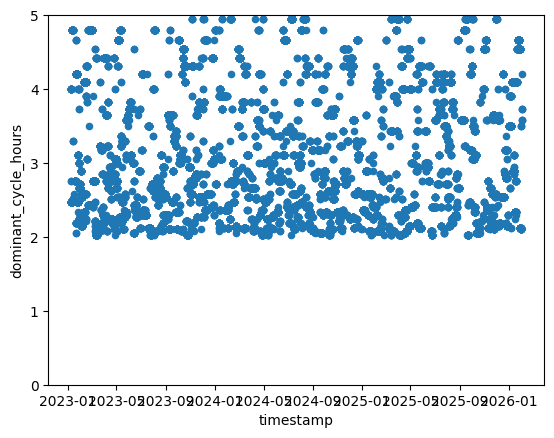

In [21]:
cycle_df.plot.scatter(x='timestamp',y='dominant_cycle_hours')
plt.ylim(0,5)

In [22]:
cycle_df.mean()

timestamp               2024-07-21 09:25:56.402468608
dominant_cycle_hours                         7.169422
dtype: object

In [23]:
cycle_df['dominant_cycle_hours'].value_counts()

dominant_cycle_hours
2.584615     970
2.333333     628
4.307692     621
4.097561     598
2.301370     596
            ... 
84.000000    117
5.793103      96
10.500000     77
8.000000      76
7.304348      68
Name: count, Length: 83, dtype: int64

In [24]:
import sys
sys.executable


'/opt/homebrew/Cellar/jupyterlab/4.4.6/libexec/bin/python'